In [1]:
# Standard modules
import pdb
import os
import sys
import matplotlib.pyplot as plt

sys.path.append('..')
from simstackwrapper import SimstackWrapper

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Import .fits table

In [2]:
from astropy.io import fits
path_cosmos2020 = os.path.join(os.environ['CATSPATH'], "cosmos","COSMOS2020_CLASSIC_R1_v2.0.fits")
if os.path.isfile(path_cosmos2020):
    print('Open ',path_cosmos2020)
    with fits.open(path_cosmos2020) as hdul:
        hdul.verify('fix')
        cosmos_catalog = hdul[1].data
else:
    print(path_cosmos2020, ' not found')

Open  D:\catalogs\cosmos\COSMOS2020_CLASSIC_R1_v2.0.fits


In [4]:
import pandas as pd
cosmos2020 = pd.DataFrame(cosmos_catalog)

In [5]:
cosmos2020.head()

,ID,ALPHA_J2000,DELTA_J2000,X_IMAGE,Y_IMAGE,ERRX2_IMAGE,ERRY2_IMAGE,ERRXY_IMAGE,FLUX_RADIUS,KRON_RADIUS,...,ez_ssfr_p025,ez_ssfr_p160,ez_ssfr_p500,ez_ssfr_p840,ez_ssfr_p975,ez_Av_p025,ez_Av_p160,ez_Av_p500,ez_Av_p840,ez_Av_p975
0,1,151.008534,1.398278,1304.953247,2579.132324,0.000009,0.000010,-8.461303e-07,NaN,NaN,...,3.073000e-14,3.306278e-14,3.696300e-14,3.828873e-14,3.828873e-14,0.704550,0.809278,0.896577,0.961172,1.070924
1,2,151.028825,1.404349,818.016785,2725.062988,0.000017,0.000017,-8.587199e-07,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,151.007706,1.398440,1324.814453,2583.007812,0.006722,0.008490,-7.216642e-04,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,150.162372,1.391619,21610.509766,2415.219971,0.031749,0.016943,6.141999e-06,NaN,NaN,...,1.191863e-10,1.356004e-10,1.582931e-10,1.872021e-10,2.076506e-10,1.659753,1.739529,1.869392,1.989442,2.089466
4,5,149.540181,1.391537,36540.632812,2414.936523,0.030666,0.016909,3.998309e-03,NaN,NaN,...,5.692379e-12,1.106644e-11,8.179705e-11,1.089352e-08,1.089352e-08,0.032678,0.032678,2.129271,3.005573,3.125110


# Convert to vaex for speed

In [10]:
import vaex
vaex_df = vaex.from_pandas(cosmos2020, copy_index=False)

In [ ]:
# Export to hdf5 for more efficient use later
path_cosmos2020_hdf5 = os.path.join(os.environ['CATSPATH'], "cosmos","cosmos2020.hdf5")
vaex_df.export_hdf5(path_cosmos2020_hdf5)

In [12]:
# Convert flux to magnitude
# AB = -2.5 log S (Jy) + 8.9
vaex_df['rest_AB_U'] = (-2.5 * np.log10(vaex_df.ez_restU * 1e6) + 8.9)
vaex_df['rest_AB_V'] = (-2.5 * np.log10(vaex_df.ez_restV * 1e6) + 8.9)
vaex_df['rest_AB_J'] = (-2.5 * np.log10(vaex_df.ez_restJ * 1e6) + 8.9)

In [13]:
# Estimate rest-frame U-V and V-J
vaex_df['ez_restU-V']=(vaex_df.rest_AB_U - vaex_df.rest_AB_V) 
vaex_df['ez_restV-J']=(vaex_df.rest_AB_V - vaex_df.rest_AB_J)

In [41]:
# Extract subset of array and drop nans
features = ['ALPHA_J2000','DELTA_J2000','lp_zBEST','lp_mass_med','ez_restU-V','ez_restV-J','lp_sSFR_med','lp_type']
uvj_df_raw = vaex_df[features].dropna()
uvj_df = uvj_df_raw[uvj_df_raw['lp_type'] > -99]

In [48]:
print(np.unique(uvj_df['lp_type'].values), ': unique values present in lp_type')
print(np.sum(uvj_df['lp_type'].values == -99), ' stars?')
print(np.sum(uvj_df['lp_type'].values == 0), ' galaxies')
print(np.sum(uvj_df['lp_type'].values == 1), ' agn')

[0 1]  unique values present in lp_type
0  stars?
710077  galaxies
8523  agn


In [43]:
uvj_df.head()

#,ALPHA_J2000,DELTA_J2000,lp_zBEST,lp_mass_med,ez_restU-V,ez_restV-J,lp_sSFR_med,lp_type
0,150.753,1.60333,1.2724,8.4021,0.272594,0.614739,-8.558,0
1,150.775,1.6034,2.8991,9.16265,0.0517635,-0.34334,-8.32349,0
2,150.768,1.60326,0.9599,8.703,0.828829,0.20003,-8.88367,0
3,150.73,1.60344,0.36,6.8586,0.118297,-0.168686,-8.45414,0
4,150.763,1.60347,1.2045,9.19418,1.01148,0.973295,-8.96474,0
5,150.773,1.60339,0.4521,7.9998,0.683142,0.0741138,-8.86948,0
6,150.751,1.60363,0.9492,8.57284,1.01296,0.85365,-8.90076,0
7,150.728,1.60363,1.3587,8.7253,0.493776,-0.00156593,-8.67073,0
8,150.69,1.60371,4.5398,9.61413,0.01161,-0.572286,-8.34746,0
9,150.746,1.60369,1.3687,8.35156,0.533897,-0.477738,-8.58341,0


# Export simplified, nan-free table, to csv

In [15]:
path_cosmos2020_csv = os.path.join(os.environ['CATSPATH'], "cosmos","cosmos2020_UVJ.csv")
uvj_df.export_csv(path_cosmos2020_csv)

C:\Users\viero\anaconda3\envs\simstack\lib\site-packages\vaex\functions.py:95: RuntimeWarning: invalid value encountered in log10
  result = function(*numpy_data, **kwargs)


# Plot U-V/V-J vs specific star-formation rate

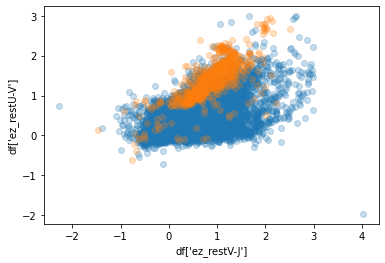

In [32]:
sfr_cut = -9.5
ns=10000
uvj_df[:ns].scatter(uvj_df['ez_restV-J'],uvj_df['ez_restU-V'], selection = uvj_df['lp_sSFR_med'] > sfr_cut, alpha=0.25)
uvj_df[:ns].scatter(uvj_df['ez_restV-J'],uvj_df['ez_restU-V'], selection = uvj_df['lp_sSFR_med'] <= sfr_cut, alpha=0.25)